 # please re-start kernel if these packages are installed for the first time

In [1]:
# ! pip install -e /user/hwang/Jupyter_notebooks/pkgs/objFuncs_REA
# ! pip install -e /user/hwang/Jupyter_notebooks/pkgs/pyBO

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
import datetime
import concurrent
from epics import caget

In [3]:
from objFuncs.REA_maximize_FC import maximize_FC1058 as maximize_FC
import objFuncs
from objFuncs.util import plot_obj_history
from pyBO import pyBO

[19:33:36.766] INFO: phantasy.library.operation.core: Load new machine: 'FRIB', segment: 'LINAC'
[19:33:36.768] INFO: phantasy.library.parser.config: Importing FRIB from /projects/rea3/AP-ReA/apps/.phyapps/phantasy-machines/FRIB
[19:33:36.770] INFO: phantasy.library.parser.config: Loading machine configuration from /projects/rea3/AP-ReA/apps/.phyapps/phantasy-machines/FRIB/phantasy.ini
[19:33:36.771] INFO: phantasy.library.operation.lattice: Loading segment: 'LINAC'


   _test : False
   _ensure_set_timeout : 30
   _ensure_set_timewait_after_ramp : 0.25
   _fetch_data_time_span : 2.05
   _return_obj_var : False
   _check_chopper_blocking : False


[19:33:36.964] INFO: phantasy.library.operation.lattice: UNICORN policy will be loaded from /projects/rea3/AP-ReA/apps/.phyapps/phantasy-machines/unicorn/unicorn-data.xls.
[19:33:36.965] WARNING: phantasy.library.operation.lattice: No aligment data is read.
[19:33:36.966] INFO: phantasy.library.operation.lattice: Device polarity data is loaded from /projects/rea3/AP-ReA/apps/.phyapps/phantasy-machines/polarity/polarity_data.csv.
[19:33:36.967] INFO: phantasy.library.operation.lattice: Loading PV data from CSV/SQLite: /projects/rea3/AP-ReA/apps/.phyapps/phantasy-machines/FRIB/linac/all_channels.csv
[19:33:36.967] INFO: phantasy.library.pv.datasource: Set source to be CSV table: all_channels.csv.
[19:33:37.529] INFO: phantasy.library.operation.lattice: Model data directory: /user/rea3/phantasy_data/20240315/model_data/data_193337
[19:33:37.591] INFO: phantasy.library.operation.lattice: Found 13828 PVs in 'LINAC'.
[19:33:39.586] INFO: phantasy.library.operation.lattice: 'LINAC' has 1353 e

In [4]:
objFuncs._global_machineIO._test = False
objFuncs._global_machineIO._fetch_data_time_span = 2.05
objFuncs._global_machineIO._ensure_set_timewait_after_ramp = 0.25
# objFuncs._global_machineIO.fetch_data = objFuncs.construct_machineIO._manual_fetch_data

objFuncs._global_machineIO.view()

   _test : False
   _ensure_set_timeout : 30
   _ensure_set_timewait_after_ramp : 0.25
   _fetch_data_time_span : 2.05
   _return_obj_var : False
   _check_chopper_blocking : False
   _n_popup_ramping_not_OK : 0
   _verbose : False


In [6]:
ion = caget("REA_EXP:ELMT")
Q = int(caget("REA_EXP:Q"))
A = int(caget("REA_EXP:A"))
AQ = A/Q
ion = str(A)+ion+str(Q)
print(ion, 'A/Q=',AQ)

20Ne9 A/Q= 2.2222222222222223


In [7]:
now0 = datetime.datetime.now()
now0str = str(now0)[:str(now0).rfind(':')].replace(' ','_').replace(':','').replace('-','')
fname = '[REA][pyBO]'+now0str+'_'+ion+'_FC1448'
fname

'[REA][pyBO]20240315_1933_20Ne9_FC1448'

# Decision parameters and range

In [8]:
decision_CSETs = [#'REA_BTS10:DCHE_D0948:V_CSET',
                  #'REA_BTS10:DCVE_D0948:V_CSET',
                 'REA_BTS30:DCH_D1305:I_CSET',
                 'REA_BTS30:DCV_D1305:I_CSET',
                 'REA_BTS30:DCH_D1345:I_CSET',
                 'REA_BTS30:DCV_D1345:I_CSET',
#                  'REA_BTS26:DCH_D1219:I_CSET',
#                  'REA_BTS26:DCV_D1219:I_CSET',
#                  'REA_BTS30:DCH_D1270:I_CSET',
#                  'REA_BTS30:DCV_D1270:I_CSET',
#                  'REA_BTS30:DCH_D1305:I_CSET',
#                  'REA_BTS30:DCV_D1305:I_CSET',
#                  'REA_BTS30:DCH_D1345:I_CSET',
#                  'REA_BTS30:DCV_D1345:I_CSET',
                  ]

In [11]:
ave,_ = objFuncs._global_machineIO.fetch_data(decision_CSETs,0.1)

decision_min = np.round(ave - 5)
decision_max = np.round(ave + 5)
local_bound_fraction = 1.0

decision_tols = [1]*len(ave)
pd.DataFrame([ave,decision_min,decision_max,decision_tols],columns=decision_CSETs,index=['current','min','max','tol']).T

,current,min,max,tol
REA_BTS30:DCH_D1305:I_CSET,5.850266,1.0,11.0,1.0
REA_BTS30:DCV_D1305:I_CSET,-22.510305,-28.0,-18.0,1.0
REA_BTS30:DCH_D1345:I_CSET,-17.464326,-22.0,-12.0,1.0
REA_BTS30:DCV_D1345:I_CSET,35.506558,31.0,41.0,1.0


In [12]:
assert len(decision_CSETs) == len(decision_min) == len(decision_max)
if decision_tols is not None:
    assert len(decision_CSETs) == len(decision_tols) 
assert np.all(np.array(decision_min)<np.array(decision_max))

# Objectives

### manual definition of obj

In [13]:
FC0999 = 50e-12
FC='REA_BTS19:MTER_N0001:I_RD'
FC='REA_BTS34:MTER_N0001:I_RD'
objective_goal   = {FC: {'more than': FC0999}}
objective_weight = {FC: 1}
objective_norm   = {FC: 0.1*FC0999}
# objective_goal   = {'REA_WK01:FC_D1058:BC_RD': {'more than': FC0999}}
# objective_weight = {'REA_WK01:FC_D1058:BC_RD': 1}
# objective_norm   = {'REA_WK01:FC_D1058:BC_RD': 1e-12}

In [14]:
objFuncs._global_machineIO.caget(FC)/1e-12

8.782192

### regularization

In [15]:
# reg_goal = {key:0.5*(val_max+val_min) if 'PSD' in key else 0 for key,val_min,val_max in zip(decision_CSETs,decision_min,decision_max)}
# reg_norm = {key:0.5*(val_max-val_min) for key,val_min,val_max in zip(decision_CSETs,decision_min,decision_max)}
# reg_weight = {key:0.1 if 'PSD' in key else 0.05 for key in decision_CSETs}   

In [16]:
# objective_goal.update(reg_goal)
# objective_norm.update(reg_norm)
# objective_weight.update(reg_weight)

In [17]:
# pd.DataFrame((objective_goal,objective_norm,objective_weight),index=['goal','norm','weight']).T

### construct objectives class

In [18]:
obj = maximize_FC(
    decision_CSETs= decision_CSETs,
    decision_min  = decision_min,
    decision_max  = decision_max,
    decision_tols = decision_tols,
    objective_goal = objective_goal,
    objective_weight = objective_weight,
    objective_norm = objective_norm,
    objective_fill_none_by_init = True,
)

======== class info ========
init_time: 2024-03-15 19:35:06.860854
class_hierarchy: [
    maximize_FC1058, maximize_FC, objFuncGoals
    objFuncBase]
machineIO: <objFuncs.construct_machineIO.construct_machineIO object at 0x7f19c40e2cd0>
decision_CSETs: [
    REA_BTS30:DCH_D1305:I_CSET, REA_BTS30:DCV_D1305:I_CSET, REA_BTS30:DCH_D1345:I_CSET
    REA_BTS30:DCV_D1345:I_CSET]
decision_min: [  1. -28. -22.  31.]
decision_max: [ 11. -18. -12.  41.]
decision_bounds: [[  1.  11.]
 [-28. -18.]
 [-22. -12.]
 [ 31.  41.]]
decision_RDs: [
    REA_BTS30:DCH_D1305:I_RD, REA_BTS30:DCV_D1305:I_RD, REA_BTS30:DCH_D1345:I_RD
    REA_BTS30:DCV_D1345:I_RD]
decision_tols: [1 1 1 1]
decision_couplings: None
history_buffer_size: None
logging_frequency: inf
logging_tag: 
logging_fname: None
x0: [  5.8502665  -22.51030482 -17.46432642  35.50655783]
objective_weight: {'REA_BTS34:MTER_N0001:I_RD': 1.0}
objective_goal: {'REA_BTS34:MTER_N0001:I_RD': {'more than': 5e-11}}
objective_norm: {'REA_BTS34:MTER_N0001:I_RD':

 # Prepare plot callbacks

In [19]:
# define what to plot
plot_CSETs = plot_obj_history(
                obj.history['decision_CSETs'],
                title = 'decision_CSETs',
                inline = True,
                )
plot_RDs = plot_obj_history(
                obj.history['objective_RDs'],
                title = 'objective_RDs',
                inline = True,
                )
plot_objs = plot_obj_history(
            obj.history['objectives'],
            title = 'objectives',
            inline = True,
            )
callbacks = [plot_CSETs,plot_RDs,plot_objs]


# evaluate objective and plot
def obj_callbacks(x):
    return obj(x,callbacks=callbacks)

# Run BO

### initialize BO near current set

In [20]:
x0,_ = objFuncs._global_machineIO.fetch_data(decision_CSETs,0.1)
local_min = x0 - local_bound_fraction*(obj.decision_max - obj.decision_min)
local_max = x0 + local_bound_fraction*(obj.decision_max - obj.decision_min)
local_bounds = list(zip(local_min,local_max))
x0, local_bounds

(array([  5.8502665 , -22.51030482, -17.46432642,  35.50655783]),
 [(-4.149733504803972, 15.850266495196028),
  (-32.51030481637132, -12.51030481637132),
  (-27.464326423278287, -7.464326423278287),
  (25.5065578286924, 45.5065578286924)])

scipy version mismatch. 'scipy.stat.qmc' is not imported. Using custom halton seqeunce instead


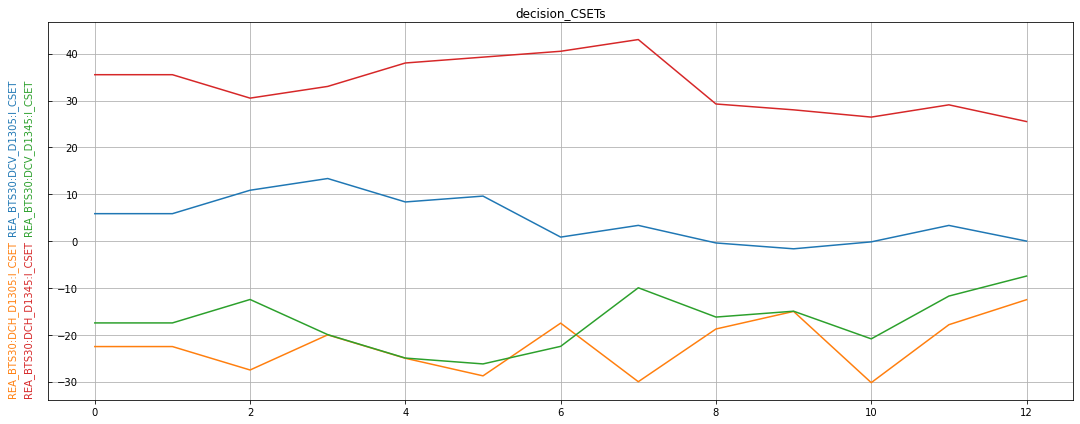

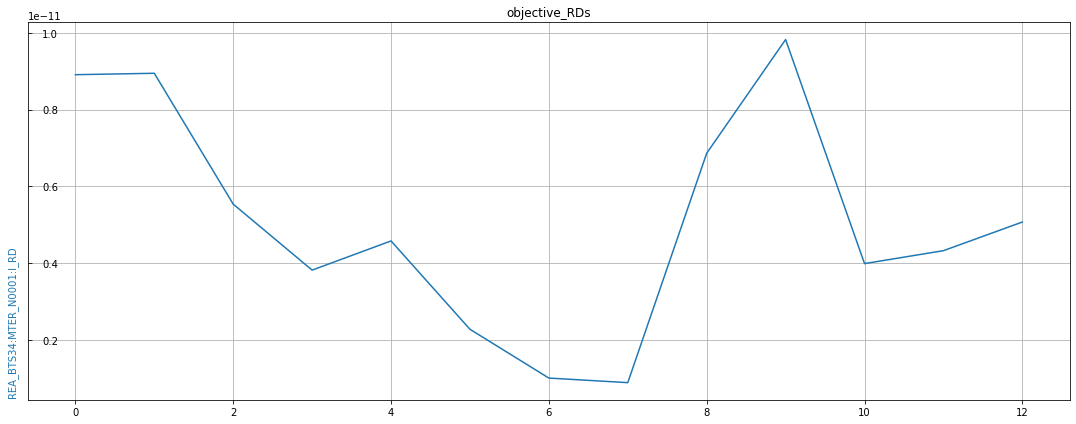

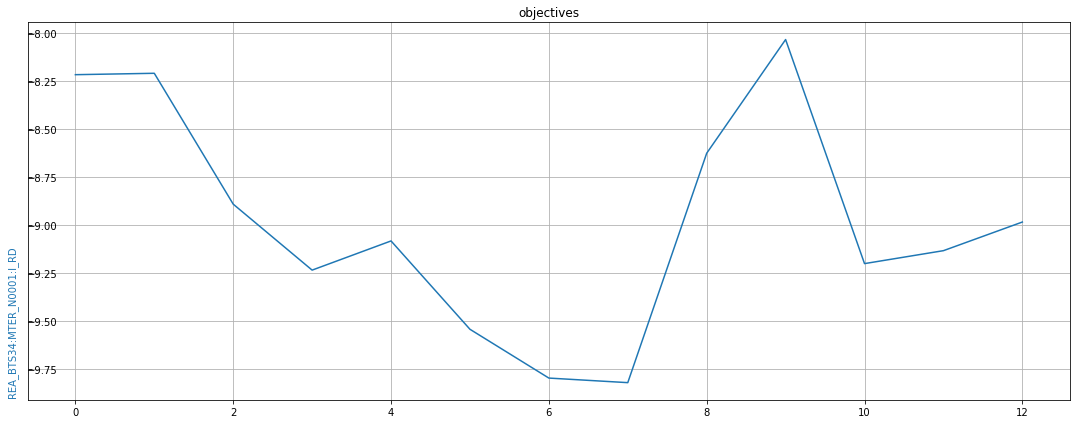

[████████████████████████████████████████] 100%/100%



In [21]:
bo, X_pending, Y_pending_future = pyBO.runBO(
                                    obj_callbacks,  
                                    bounds=local_bounds,
                                    n_init=10,
                                    x0 = obj.x0,
                                    budget = 12,
                                    batch_size=1,
                                    path="./log/",
                                    tag=fname+'_pyBO_history',
                                    write_log = False)
for f in callbacks:
    f.close()

In [22]:
budget = 60

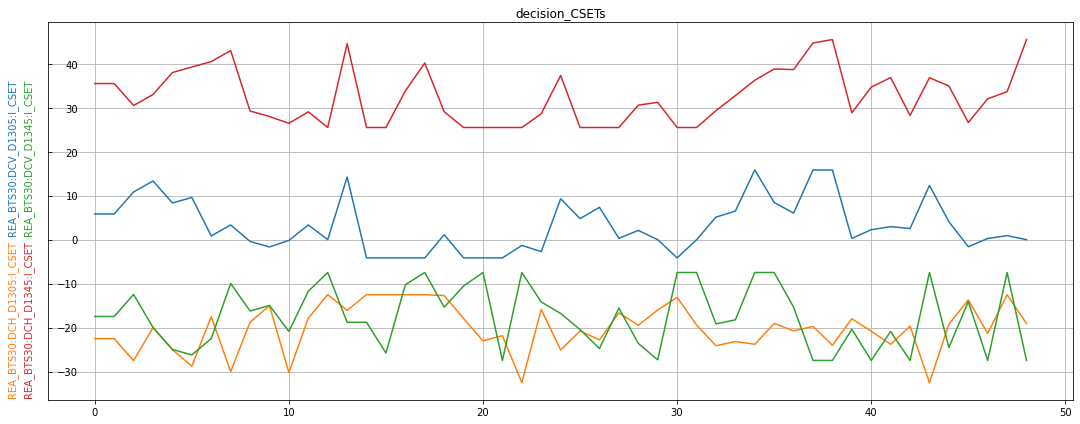

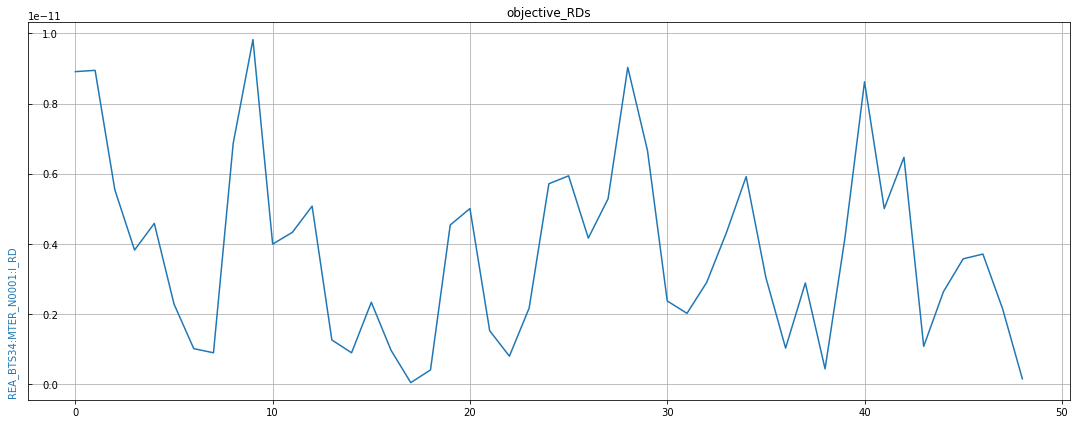

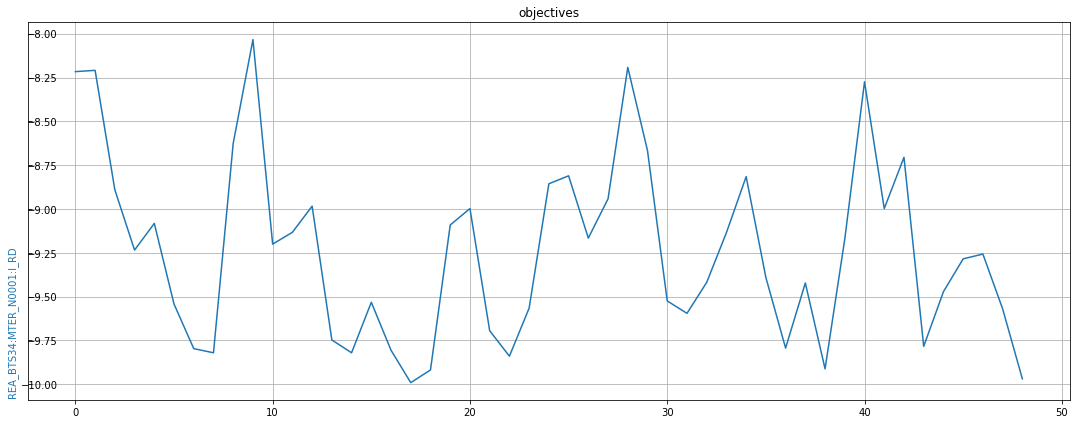

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%



In [23]:
# uncomment and run if more iteration needed
acquisition_func_args = {'beta':9}
betas = np.linspace(4,1,budget)

while(len(bo.y) < budget):
    x0,y0 = bo.best_sofar()
    local_min = x0 - local_bound_fraction*(decision_max - decision_min)
    local_max = x0 + local_bound_fraction*(decision_max - decision_min)
    local_bounds = list(zip(local_min,local_max))
    beta = betas[len(bo.y)]
    acquisition_func_args['beta'] = beta
    
    X_pending, Y_pending_future= bo.loop( 
                                    n_loop=3,  # number of additional optimization interation
                                    func_obj = obj_callbacks,
                                    X_pending = X_pending, 
                                    Y_pending_future = Y_pending_future,
                                    acquisition_func_args = acquisition_func_args,
                                    batch_size = 1,
                                    write_log = False,
                                    )
for f in callbacks:
    f.close()

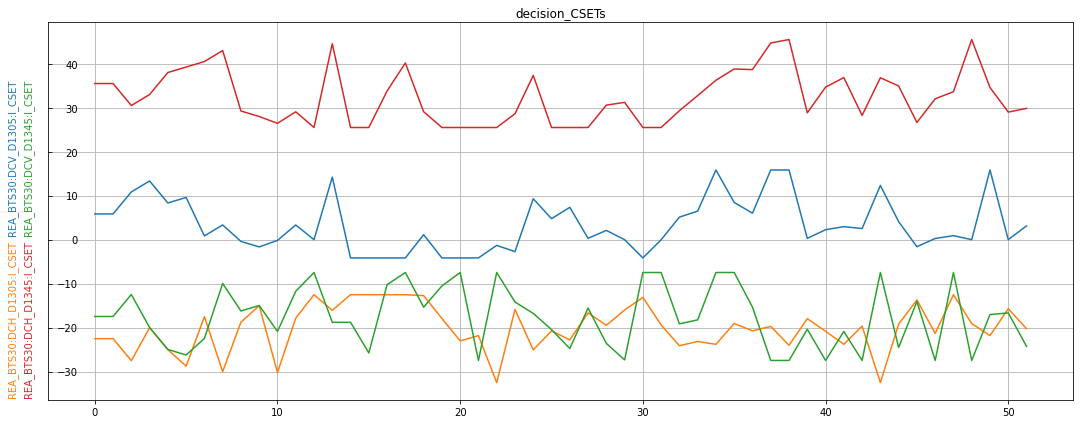

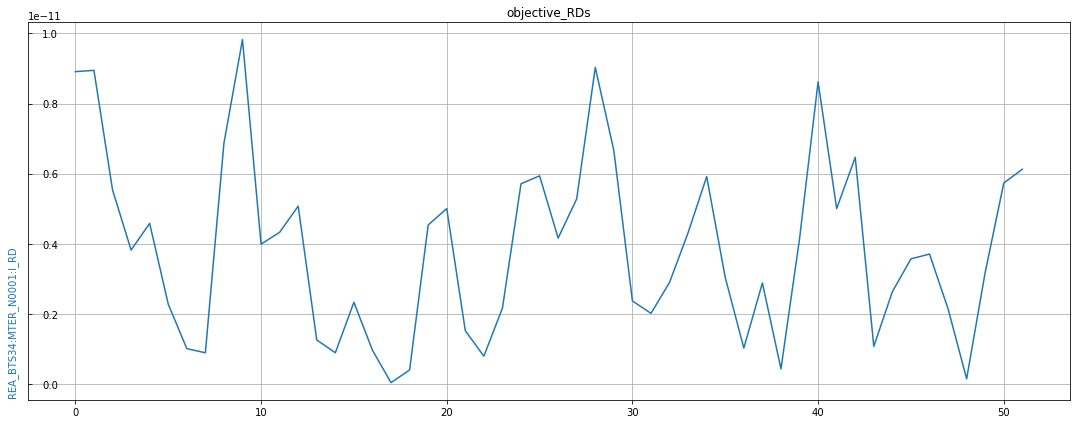

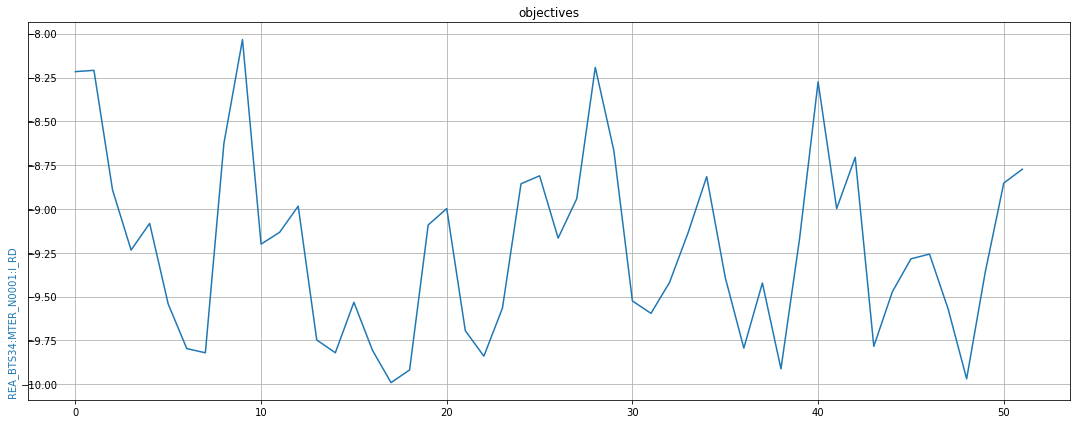

[████████████████████████████████████████] 100%/100%



In [24]:
x0,y0 = bo.best_sofar()
local_min = x0 - local_bound_fraction*(decision_max - decision_min)
local_max = x0 + local_bound_fraction*(decision_max - decision_min)
local_bounds = list(zip(local_min,local_max))
beta = 0.1
acquisition_func_args['beta'] = beta

X_pending, Y_pending_future= bo.loop( 
                                n_loop=3,  # number of additional optimization interation
                                func_obj = obj_callbacks,
                                X_pending = X_pending, 
                                Y_pending_future = Y_pending_future,
                                acquisition_func_args = acquisition_func_args,
                                batch_size = 1,
                                write_log = False,
                                )
for f in callbacks:
    f.close()

In [25]:
# if python raised error, use the following to re-use all the data until now
# bo, X_pending, Y_pending_future = pyBO.runBO(
#     obj_callbacks,  
#     bounds=obj.decision_bounds,
#     n_init=n_init,
#     x0 = np.array(obj.history['decision_RDs']['values']),
#     y0 = np.array(obj.history['objectives']['values']),
#     budget = budget,
#     batch_size=1,
#     path="./log/",
#     tag=fname+'_pyBO_history',
#     write_log = False)
# for f in callbacks:
#     f.close()

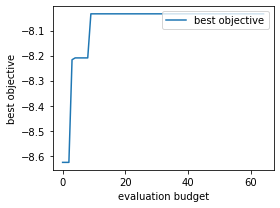

In [26]:
fig,ax = plt.subplots(figsize=(4,3))
ax = bo.plot_obj_history(ax=ax,plot_best_only=True)
# ax.vlines(n_init,*ax.get_ylim(),color='k')
fig.tight_layout()
# fig.savefig(fname+'_history.png',dpi=90)

In [27]:
# set to best solution 
x_best,y_best_old = bo.best_sofar()
y_best_new = obj(x_best)
print(x_best,y_best_old[0],y_best_new)   # check if best solution objective value is consistent

[ -1.6497335  -15.01030482 -14.96432642  28.00655783] -8.033534426448043 -8.804214357128574


# Visualize Surrogate model

In [28]:
# fixed_values_for_each_dim = {2:x_best[2],3:x_best[3]}  # fix values to visualize high dim surrogate model
fixed_values_for_each_dim = None              # do not fix values but project maximum. Can take long time to plot
batch_size = 1

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%



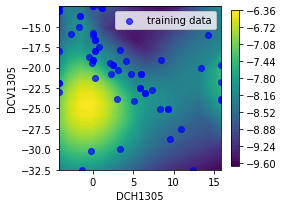

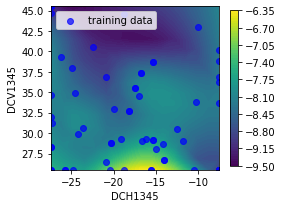

In [29]:
for i in range(int(len(decision_CSETs)/2)):
    fig,ax = plt.subplots(figsize=(4,3))
    bo.plot_model_2D_projection(project_maximum=True,
                                dim_xaxis = 2*i,
                                dim_yaxis = 2*i+1,
                                grid_ponits_each_dim = 16,
                                fixed_values_for_each_dim=fixed_values_for_each_dim,
                                fig=fig,ax=ax);
    ax.legend()
    pv_x = obj.decision_CSETs[2*i]
    pv_y = obj.decision_CSETs[2*i+1]
    pv_x = pv_x[pv_x.find(':')+1:]
    pv_y = pv_y[pv_y.find(':')+1:]
    pv_x = pv_x[:pv_x.find(':')].replace('_D','')
    pv_y = pv_y[:pv_y.find(':')].replace('_D','')
    ax.set_xlabel(pv_x)
    ax.set_ylabel(pv_y)
    fig.tight_layout()
#     fig.savefig(fname+'_'+pv_x+'_'+pv_y+'_.png',dpi=90)

In [30]:
pd.DataFrame([x_best],columns=decision_CSETs,index=['solution']).T

,solution
REA_BTS30:DCH_D1305:I_CSET,-1.649734
REA_BTS30:DCV_D1305:I_CSET,-15.010305
REA_BTS30:DCH_D1345:I_CSET,-14.964326
REA_BTS30:DCV_D1345:I_CSET,28.006558
